In [1]:

import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from category_encoders import OneHotEncoder
# from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

## Import Data

In [2]:
# from country_converter import CountryConverter
# cc = CountryConverter()


In [3]:
import logging

# Suppress country_converter warnings
logging.getLogger("country_converter").setLevel(logging.ERROR)


In [4]:
import os
import pandas as pd
import country_converter as cc  

def wrangle(filepath):
    """
    Read multiple disaster CSVs, clean them safely, and return a single DataFrame.
    
    Parameters:
    files (list): List of CSV files in filepath
    
    Returns:
    pd.DataFrame: Cleaned, concatenated DataFrame
    """
    dataframes = []

    for file in filepath:
        # print(f"Processing: {filepath}")
        # Extract disaster type from filename
        disaster_type = os.path.basename(file).replace('.csv','')
        df = pd.read_csv(file)

        # Split coordinates into longitude and latitude 
        if 'coordinates' in df.columns:
            df[['longitude','latitude']] = df['coordinates'].str.strip('[]').str.split(',', expand=True)
            df[['longitude', 'latitude']] = df[['longitude', 'latitude']].astype(float)

        # Standardize country names
        if 'iso3' in df.columns:
            df['iso3'] = df['iso3'].replace({"ROM":"ROU", "ANG":"AGO", "RWD":"RWA", "ALG":"DZA"})
            df['Country'] = cc.convert(df['iso3'], to='name_short', not_found=None)  

       
        # Convert dates to Nairobi timezone
        for time in ['fromdate','todate']:
            if time in df.columns:
                df[time] = pd.to_datetime(df[time], errors='coerce')
                df[time] = df[time].dt.tz_localize('UTC', ambiguous='NaT').dt.tz_convert('Africa/Nairobi')

        # Event Disaster cleaning
        dtype = disaster_type.lower()
        if dtype == 'drought':
            df['severity(km2)'] = pd.to_numeric(df.get('severity', pd.Series()), errors='coerce')
            df['Duration(days)'] = pd.to_numeric(df.get('Duration', pd.Series()).str.extract(r'(\d+)')[0], errors='coerce')
        elif dtype == 'earthquake':
            df['Magnitude(M)'] = pd.to_numeric(df.get('Earthquake Magnitude', pd.Series()).str.replace('M','', regex=False), errors='coerce')
            df['Depth(km)'] = pd.to_numeric(df.get('Depth', pd.Series()).str.replace(r'[^\d.]','', regex=True), errors='coerce')
        elif dtype == 'eruption':
            df.rename(columns={"Max Volc. Explosivity Index VEI": "Severity(VEI)"}, inplace=True)
        elif dtype == 'flood':
            df.rename(columns={"severity": "Severity(metres)"}, inplace=True)
            #df['Deaths'] = pd.to_numeric(df.get('Death', 0).fillna(0), errors='coerce').astype('Int64')
            df['Deaths'] = pd.to_numeric(df.get('Death', pd.Series()).fillna(0), errors='coerce').astype('Int64')
        elif dtype == 'forest fires':
            df.rename(columns={"severity": "Severity(ha)"}, inplace=True)
            if 'People affected' in df.columns:
                df['People affected'] = pd.to_numeric(df['People affected'].str.extract(r'(\d+)')[0], errors='coerce')
        elif dtype == 'tropical cyclone':
            df['Max. Windspeed'] = pd.to_numeric(df.get('Maximum wind speed', pd.Series()).str.extract(r'(\d+)')[0], errors='coerce')

        # Append cleaned dataframe
        dataframes.append(df)

    # Concatenate all cleaned dataframes
    data = pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()
    return data


In [5]:
import glob
files = glob.glob('Global Disaster Events/Unclean/*.csv')
# files

In [6]:
# READ DROUGHT DATA ONLY
# df_drought = wrangle([files[0]])
# df_drought.head(2)

In [7]:
df = wrangle(files) 

In [8]:
# df.info()
df.columns

Index(['coordinates', 'name', 'description', 'htmldescription', 'alertlevel',
       'alertscore', 'episodealertlevel', 'episodealertscore', 'country',
       'fromdate', 'todate', 'severity', 'severitytext', 'source', 'iso3',
       'eventtype', 'GDACS ID', 'Name', 'Countries', 'Start Date', 'Duration',
       'Impact', 'longitude', 'latitude', 'Country', 'severity(km2)',
       'Duration(days)', 'Earthquake Magnitude', 'Depth', 'Exposed Population',
       'Capacity', 'Magnitude(M)', 'Depth(km)', 'Exposed Population 30km',
       'Exposed Population 100km', 'Severity(VEI)',
       'Population Exposure Index PEI', 'Severity(metres)', 'Death',
       'Displaced', 'GDACS_ID', 'Deaths', 'Severity(ha)', 'People affected',
       'Start Date - Last detection', 'Duration (days)', 'Burned area',
       'Exposed countries', 'Exposed population', 'Maximum wind speed',
       'Maximum storm surge', 'Vulnerability', 'Max. Windspeed'],
      dtype='object')

### Feature Selection 

In [9]:
cols = ['fromdate', 'todate', 'longitude', 'latitude', 'Country', 'alertlevel', 'alertscore', 
        'severity(km2)','iso3', 'eventtype', 'Impact', 'Duration(days)', 'Magnitude(M)', 
        'Depth(km)', 'Severity(VEI)','Severity(metres)', 'Deaths', 'Displaced', 'Severity(ha)', 
        'People affected', 'Max. Windspeed']

mask = df[cols].copy()  # Use .copy() to avoid SettingWithCopyWarning

In [10]:
mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28163 entries, 0 to 28162
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype                         
---  ------            --------------  -----                         
 0   fromdate          28163 non-null  datetime64[ns, Africa/Nairobi]
 1   todate            28163 non-null  datetime64[ns, Africa/Nairobi]
 2   longitude         28163 non-null  float64                       
 3   latitude          28163 non-null  float64                       
 4   Country           28163 non-null  object                        
 5   alertlevel        28163 non-null  object                        
 6   alertscore        28163 non-null  int64                         
 7   severity(km2)     1780 non-null   float64                       
 8   iso3              26866 non-null  object                        
 9   eventtype         28163 non-null  object                        
 10  Impact            1780 non-null   object      

In [11]:
# Map each country to a continent

# import country_converter as cc
# df['continent'] = coco.convert(df['iso3'], to='continent')

<font size="+3"><strong> Exploratory Data Analysis </strong></font>

In [12]:
mask.head(3)

,fromdate,todate,longitude,latitude,Country,alertlevel,alertscore,severity(km2),iso3,eventtype,...,Duration(days),Magnitude(M),Depth(km),Severity(VEI),Severity(metres),Deaths,Displaced,Severity(ha),People affected,Max. Windspeed
0,2017-07-21 03:00:00+03:00,2019-02-09 18:07:00+03:00,11.087,53.882,Germany,Green,1,80936.0,DEU,DR,...,569.0,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
1,2017-07-21 03:00:00+03:00,2019-02-09 18:07:00+03:00,11.087,53.882,Germany,Green,1,80936.0,DEU,DR,...,569.0,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN
2,2017-07-21 03:00:00+03:00,2019-02-09 18:07:00+03:00,11.087,53.882,Germany,Green,1,80936.0,DEU,DR,...,569.0,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN


In [13]:
mask.describe()

,longitude,latitude,alertscore,severity(km2),Duration(days),Magnitude(M),Depth(km),Severity(VEI),Severity(metres),Deaths,Severity(ha),People affected,Max. Windspeed
count,28163.000000,28163.000000,28163.000000,1.780000e+03,1780.000000,20296.000000,14181.000000,167.000000,2441.000000,2441.0,3055.000000,3055.000000,405.000000
mean,30.056029,10.766468,1.045059,1.440725e+05,325.580337,4.812830,74.411105,3.808383,4.061249,116.712003,13820.713912,703.096236,160.432099
std,107.951823,28.806356,0.238939,2.228164e+05,234.497944,0.547146,123.448485,1.202077,2.689350,3247.666439,18283.516322,5682.430898,67.016759
min,-179.990000,-66.860000,1.000000,1.457000e+03,20.000000,1.500000,0.000000,2.000000,0.000000,0.0,499.000000,0.000000,56.000000
25%,-70.309500,-11.182250,1.000000,3.195100e+04,143.000000,4.600000,10.000000,3.000000,0.000000,0.0,6207.000000,0.000000,101.000000
50%,45.000000,9.932608,1.000000,7.778000e+04,245.000000,4.800000,33.000000,4.000000,4.850000,4.0,8390.000000,0.000000,148.000000
75%,126.895800,36.440000,1.000000,1.444910e+05,457.000000,5.100000,72.600000,5.000000,6.180000,22.0,13866.500000,10.000000,213.000000
max,180.000000,86.893200,3.000000,1.677855e+06,1024.000000,8.800000,693.700000,6.000000,8.410000,160000.0,354490.000000,170150.000000,333.000000


*Mean is > than Median for both Severity(ha) and Depth(km).*

In [14]:
# mask[["Depth(km)","Severity(ha)"]].describe()

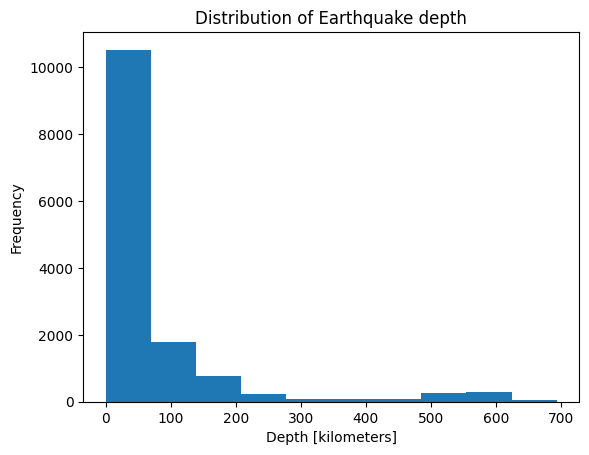

In [15]:
# Use Matplotlib to create histogram of "area_m2"
plt.hist(mask["Depth(km)"])
# Add x-axis label
plt.xlabel("Depth [kilometers]")
# Add y-axis label
plt.ylabel("Frequency")
# Add title
plt.title("Distribution of Earthquake depth");

In [16]:
# mask.head()

### Top 10 countries with the highest "Drought-disaster" impact by average

Use the [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) method to create a Series named `average_impact_by_country`, where the index contains each Country in the dataset and the values correspond to the average severity or impact for that Country by Drought. The series is sorted from highest to lowest average impact. 

In [17]:
average_impact_by_country = mask.groupby('Country')['severity(km2)'].mean().sort_values(ascending=False)
average_impact_by_country.head(10)

Country
Albania         743086.219512
Iraq            527384.000000
Burkina Faso    486063.000000
Moldova         415346.000000
Austria         410725.142857
Afghanistan     409134.361702
Brazil          332702.017544
Belgium         331963.300000
Iran            304885.555556
Kazakhstan      258144.960000
Name: severity(km2), dtype: float64

## Create a dataframe for the given African countries

Use the [`groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) method to create a Series named `average_impact_in_Africa`, where the index contains each Country in the Africa dataset and the values correspond to the average severity or impact for that Country by Drought or Floods. The series is sorted from highest to lowest average impact. 

In [18]:
Africa = mask[mask['Country'].isin(["Kenya", "Ethiopia", "Somalia", "Lebanon",
    "Nigeria", "South Sudan", "South Africa", "DR Congo"]) & mask['eventtype'].isin(['FL', 'DR'])]

In [19]:
df_Africa = Africa.groupby('Country')['severity(km2)'].mean().sort_values(ascending=False)
df_Africa.head()  

Country
DR Congo        203679.181818
Somalia          87260.000000
Ethiopia         80604.727273
South Africa     52380.000000
South Sudan      48739.000000
Name: severity(km2), dtype: float64

Using `df_Africa`, create a scatter plot that shows Displaced vs Flood water-levels (in metres). Make sure to use the same axis labels as your last scatter plot. The title should be `"Africa: Number of Displaced people vs. Height of water-levels (metres)"`.

In [20]:
Africa.loc[:, ["Severity(metres)", "Displaced"]] = Africa[["Severity(metres)", "Displaced"]].apply(pd.to_numeric, errors="coerce")

In [21]:
# Africa.info()

In [22]:
Africa_ = Africa.dropna(subset=["Severity(metres)", "Displaced"])

In [23]:
Africa_ = Africa_.astype({"Severity(metres)": "float", "Displaced": "float"})

In [24]:
# Keep only rows with valid values
Africa_ = Africa_[(Africa_["Displaced"] > 0) & (Africa_["Severity(metres)"] > 0)]

In [25]:
# Africa_.info()

Using `Africa_`, create a scatter plot that shows Severity(metres) vs Displaced.

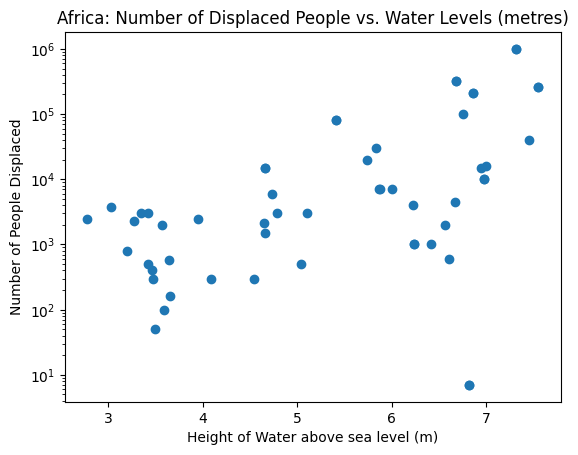

In [26]:
plt.scatter(x=Africa_["Severity(metres)"], y=Africa_["Displaced"])
plt.xlabel("Height of Water above sea level (m)")
plt.ylabel("Number of People Displaced")
plt.title("Africa: Number of Displaced People vs. Water Levels (metres)")
plt.yscale("log")   # Log scaling
plt.show()

Using the [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.Series.corr.html) method, calculate the Pearson correlation coefficient for `"Severity(metres)"` and `"price_usd"` in `Displaced`. 

In [27]:
p_correlation = Africa_["Severity(metres)"].corr(Africa_["Displaced"])
# p_correlation

### `QUESTION` 2

In [28]:
mask_ = mask[mask["Depth(km)"] > 0]

Complete the code below to create a 3D scatter plot, with `"lon"` on the x-axis, `"lat"` on the y-axis, and `"Depth(km)"` on the z-axis.

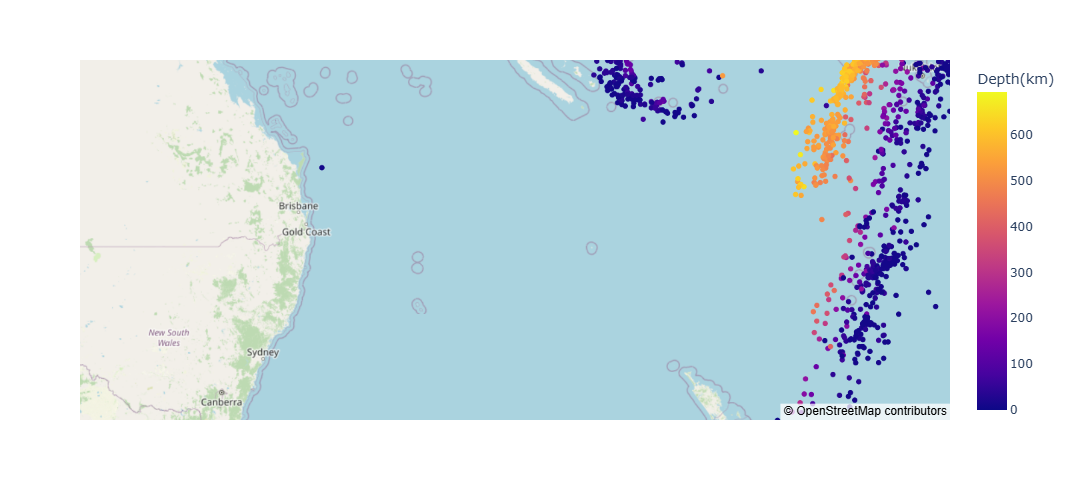

In [36]:
fig = px.scatter_mapbox(mask_, lat = "latitude", lon = "longitude", width=900, height=500, color= "Depth(km)",
                        hover_data=["Depth(km)"])  # Display depth when hovering mouse over calamity

fig.update_layout(mapbox_style="open-street-map")

fig.show()

In [30]:
Mask = mask.copy()
Mask.loc[:, "Continent"] = cc.convert(mask["Country"], to="continent")

In [31]:
pivot = Mask.pivot_table(index="Continent", columns="eventtype", 
                          aggfunc="size", fill_value=0)

In [32]:
# Create Total sum of events per Continent
pivot["Total"] = pivot.sum(axis=1)

In [33]:
pivot_sorted = pivot.assign(Total=pivot.sum(axis=1),Mean=pivot.mean(axis=1)).sort_values(by=["Total", "Mean"], ascending=False)
pivot_sorted

eventtype,DR,EQ,FL,TC,VO,WF,Total,Mean
Continent,,,,,,,,
Asia,406,6824,714,92,55,419,17020,2431.428571
America,601,4314,482,79,38,669,12366,1766.571429
Oceania,85,3431,80,43,18,487,8288,1184.000000
not found,0,2869,595,168,17,0,7298,1042.571429
Europe,262,2288,249,6,53,319,6354,907.714286
Africa,426,271,321,17,5,1161,4402,628.857143
Antarctica,0,299,0,0,0,0,598,85.428571


## Author

<a href="https://www.linkedin.com/in/andrew-kalumba-harris/">Andrew Kalumba</a><br>
<a href =""> </a>


| Date (YYYY-MM-DD) | Prepared By     | 
| ----------------- | --------------  | 
| 2025-12-05        | Author          | 


## <h3 align="center"> © Data Science 2025.  <h3/>